## 딥러닝 실습 과제 3주차 - CNN을 활용한 이미지 데이터 증강 실험

다음  네 가지 활동을 해봅시다.

01. **데이터 전처리 및 로딩**: "기존" vs "기존 + 증강"
02. **모델 설계**: CNN 기반 분류 모델 재사용 및 수정
03. **손실 함수 정의**: 각 칸에 대해 3-클래스 분류
04. **증강 적용 유무에 따른 성능 비교**

TTTDataset.zip을 불러와 문제에서 요하는 코드를 구현하세요.

💡 **데이터 구조**  
- **`image_black`** : 이미지 데이터  
- **`labels`** : 타겟 데이터  

In [ ]:
# vscode 작업을 위한 필수 패키지 설치
%pip install torch torchvision numpy matplotlib scikit-learn tqdm pillow

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import random
from PIL import Image
import json
import glob
import os

## 00. 클래스
정의한 클래스를 이용해 실행해 주세요.

In [3]:
class TTTDataset(Dataset):
    def __init__(self, image_paths, label_paths, transform=None):
        """
        틱택토 데이터셋을 PyTorch Dataset 형태로 변환.
        :param image_paths: 이미지 파일 경로 리스트
        :param label_paths: 레이블 JSON 파일 경로 리스트
        :param transform: 이미지 전처리 변환
        """
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.transform = transform
        self.data = self._load_data()

    def _load_data(self):
        """ 이미지 & 레이블 로드 """
        data = []
        # 클래스 인덱스 매핑 정의: blank=0, O=1, X=2
        label_map = {"blank": 0, "O": 1, "X": 2}

        for img_path, lbl_path in zip(self.image_paths, self.label_paths):
            # 이미지를 흑백(Grayscale)로 변환
            image = Image.open(img_path).convert("L")
            
            # JSON 레이블 로드
            with open(lbl_path, 'r') as f:
                labels = json.load(f)
            
            # 레이블을 클래스 인덱스(0, 1, 2)로 변환하고 long 타입으로 지정
            label_values = [label_map[labels.get(f"cell_{i}", "blank")] for i in range(9)]
            label_tensor = torch.tensor(label_values, dtype=torch.long)
            
            data.append((image, label_tensor))
            
        return data

    def __len__(self):
        """ 데이터셋 크기 반환 """
        return len(self.data)

    def __getitem__(self, idx):
        """ 데이터셋에서 idx 번째 샘플(이미지 & 레이블)을 가져오는 역할 """
        image, label = self.data[idx]
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

### 이미지 및 레이블 로드하기

In [5]:
# --- 01. 이미지와 레이블 파일 경로 로드 및 분류 ---

image_dir = os.path.join("../TTTDataset/image_black")
labels_dir = os.path.join("../TTTDataset/labels")

# 모든 이미지 경로 가져오기
all_image_paths = sorted(glob.glob(os.path.join(image_dir, "*.jpg")) + 
                         glob.glob(os.path.join(image_dir, "*.JPG")))

normal_image_paths = []
normal_label_paths = []
augmented_image_paths = []
augmented_label_paths = []
augmentation_suffixes = ("_affine", "_blurred", "_fog")

# 레이블 파일 매핑 생성
label_path_dict = {}
for label_path in glob.glob(os.path.join(labels_dir, "*.json")):
    label_base_name = os.path.splitext(os.path.basename(label_path))[0]
    
    # 이미지 파일명 추출
    if any(label_base_name.endswith("_labels" + suffix) for suffix in augmentation_suffixes):
        # 증강된 레이블 파일 (예: "01_labels_affine")
        for suffix in augmentation_suffixes:
            if label_base_name.endswith("_labels" + suffix):
                prefix = label_base_name[:-len("_labels" + suffix)]
                image_base_name = prefix + suffix
                break
    elif label_base_name.endswith("_labels"):
        # 일반 레이블 파일 (예: "01_labels")
        image_base_name = label_base_name[:-len("_labels")]
    else:
        continue
        
    label_path_dict[image_base_name] = label_path

# 이미지 분류
for img_path in all_image_paths:
    img_base_name = os.path.splitext(os.path.basename(img_path))[0]
    
    # 해당 이미지의 레이블 파일 찾기
    label_path = label_path_dict.get(img_base_name)
    if not label_path:
        continue
    
    # 증강 이미지인지 확인
    if any(img_base_name.endswith(suffix) for suffix in augmentation_suffixes):
        augmented_image_paths.append(img_path)
        augmented_label_paths.append(label_path)
    else:
        normal_image_paths.append(img_path)
        normal_label_paths.append(label_path)

print(f"정상 이미지 수: {len(normal_image_paths)}")
print(f"증강 이미지 수: {len(augmented_image_paths)}")

정상 이미지 수: 117
증강 이미지 수: 336


## 01. 데이터 전처리 및 로딩: "기존" vs "기존 + 증강"

💡 실험을 위한 **두 개의 DataLoader**를 구성하세요 (1주차 과제 참고)
- 기존 데이터만 사용하는 DataLoader
- 기존 데이터 + 실시간 transform 증강을 적용한 DataLoader

In [6]:
# --- 02. 이미지 전처리를 위한 transform 정의 ---

# 기본 Transform
basic_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# 증강 Transform
augmented_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    # --- 증강 기법 추가 ---
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.9, 0.95)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    # --------------------------
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [7]:
# 데이터셋 분할 및 생성
train_ratio, val_ratio = 0.6, 0.2

# 정상 데이터 인덱스 분할
normal_indices = list(range(len(normal_image_paths)))
train_normal_indices, temp_indices = train_test_split(
    normal_indices, train_size=train_ratio, random_state=42
)
val_normal_indices, test_normal_indices = train_test_split(
    temp_indices, train_size=val_ratio/(1-train_ratio), random_state=42
)

# 경로 추출
train_normal_imgs = [normal_image_paths[i] for i in train_normal_indices]
train_normal_lbls = [normal_label_paths[i] for i in train_normal_indices]
val_imgs = [normal_image_paths[i] for i in val_normal_indices]
val_lbls = [normal_label_paths[i] for i in val_normal_indices]
test_imgs = [normal_image_paths[i] for i in test_normal_indices]
test_lbls = [normal_label_paths[i] for i in test_normal_indices]

# 학습 데이터에 증강 데이터 추가 및 셔플
train_image_paths = train_normal_imgs + augmented_image_paths
train_label_paths = train_normal_lbls + augmented_label_paths
temp = list(zip(train_image_paths, train_label_paths))
random.shuffle(temp)
train_image_paths, train_label_paths = zip(*temp)

# 데이터셋 생성
train_dataset = TTTDataset(list(train_image_paths), list(train_label_paths), transform=basic_transform)
val_dataset = TTTDataset(val_imgs, val_lbls, transform=basic_transform)
test_dataset = TTTDataset(test_imgs, test_lbls, transform=basic_transform)

print(f"최종 학습 데이터셋 크기: {len(train_dataset)}")
print(f"검증 데이터셋 크기: {len(val_dataset)}")
print(f"테스트 데이터셋 크기: {len(test_dataset)}")

최종 학습 데이터셋 크기: 406
검증 데이터셋 크기: 23
테스트 데이터셋 크기: 24


In [8]:
# --- 데이터로더 생성 ---
batch_size = 16

# 베이스라인 데이터 로더 (기본 변환)
train_dataset_baseline = TTTDataset(train_image_paths, train_label_paths, transform=basic_transform)
train_loader_baseline = DataLoader(train_dataset_baseline, batch_size=batch_size, shuffle=True, drop_last=True)

# 검증/테스트 데이터셋과 로더
val_dataset = TTTDataset(val_imgs, val_lbls, transform=basic_transform)
test_dataset = TTTDataset(test_imgs, test_lbls, transform=basic_transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 증강 데이터 로더 (증강 변환 적용)
train_dataset_augmented = TTTDataset(train_image_paths, train_label_paths, transform=augmented_transform)
train_loader_augmented = DataLoader(train_dataset_augmented, batch_size=batch_size, shuffle=True, drop_last=True)

# 로더 정보 출력
print(f"Baseline - 학습: {len(train_loader_baseline)}배치, 검증: {len(val_loader)}배치, 테스트: {len(test_loader)}배치")
print(f"Augmented - 학습: {len(train_loader_augmented)}배치, 검증: {len(val_loader)}배치, 테스트: {len(test_loader)}배치")

Baseline - 학습: 25배치, 검증: 2배치, 테스트: 2배치
Augmented - 학습: 25배치, 검증: 2배치, 테스트: 2배치


## 02. 모델 설계: CNN 기반 분류 모델 재사용 및 수정
- 1채널 이미지 입력, 9 × 3-클래스 출력 구조 유지 (2주차 과제 참고)
- Dropout/Hidden Layer 등 수정 가능


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TTT_CNN(nn.Module):
    def __init__(self):
        super(TTT_CNN, self).__init__()
        
        # 초기 컨볼루션 레이어 (1채널 -> 64채널)
        self.initial_conv = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        # ResNet 스타일 블록
        self.block1 = self._make_res_block(64, 128)
        self.block2 = self._make_res_block(128, 256)
        self.block3 = self._make_res_block(256, 512)
        
        # 공간 피라미드 풀링 (다양한 스케일 특징 추출)
        self.spp = SpatialPyramidPooling([1, 2, 4])
        self.attention = SelfAttention(512)
        
        # 분류기
        self.classifier = nn.Sequential(
            nn.Linear(512 * (1 + 4 + 16), 1024),
            nn.BatchNorm1d(1024), nn.ReLU(inplace=True), nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512), nn.ReLU(inplace=True), nn.Dropout(0.3),
            nn.Linear(512, 9 * 3)  # 9개 셀 × 3 클래스
        )
        
        self._initialize_weights()

    def _make_res_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(out_channels), nn.ReLU(inplace=True),
            
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels), nn.ReLU(inplace=True),
            
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels), nn.ReLU(inplace=True)
        )

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.initial_conv(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.attention(x)
        x = self.spp(x)
        x = self.classifier(x)
        return x.view(-1, 9, 3)


class SpatialPyramidPooling(nn.Module):
    def __init__(self, levels):
        super(SpatialPyramidPooling, self).__init__()
        self.levels = levels

    def forward(self, x):
        batch_size, channels, h, w = x.size()
        features = []
        
        for level in self.levels:
            pool = nn.AdaptiveMaxPool2d((level, level))
            pooled = pool(x).view(batch_size, channels, -1)
            features.append(pooled)
        
        x = torch.cat(features, dim=2)
        return x.view(batch_size, -1)


class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super(SelfAttention, self).__init__()
        self.query_conv = nn.Conv2d(in_channels, in_channels//8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels, in_channels//8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch_size, C, width, height = x.size()
        
        # 어텐션 계산
        proj_query = self.query_conv(x).view(batch_size, -1, width*height).permute(0, 2, 1)
        proj_key = self.key_conv(x).view(batch_size, -1, width*height)
        energy = torch.bmm(proj_query, proj_key)
        attention = F.softmax(energy, dim=2)
        
        # 어텐션 적용
        proj_value = self.value_conv(x).view(batch_size, -1, width*height)
        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(batch_size, C, width, height)
        
        return self.gamma * out + x


# 모델 초기화 및 장치 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TTT_CNN().to(device)
print(f"Using device: {device}")
print(model)

Using device: cpu
TTT_CNN(
  (initial_conv): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (block1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
  )
  (block2): Sequential(
    (0): Conv2d(128, 256, ke

## 03. 손실 함수 정의: 각 칸에 대해 3-클래스 분류
- 다중 클래스 분류이므로 CrossEntropyLoss 사용 가능
- 9개 칸을 각각 분류하는 방식으로 모델 구성
- Adam 옵티마이저 사용 권장

In [ ]:
# --- 손실 함수 및 최적화기 정의 ---
import torch.nn as nn
import torch.optim as optim

# 손실 함수 - 다중 클래스 분류를 위한 Cross Entropy Loss
criterion = nn.CrossEntropyLoss()

# 학습 파라미터 설정
num_epochs = 30
learning_rate = 0.0006

학습에 사용할 장치: cpu


## 04. 증강 적용 유무에 따른 성능 비교
- 두 개의 DataLoader로 두 번 실험
- 같은 모델 구조로 학습 → 성능 차이 비교 (정확도/학습 안정성/과적합 여부 등)

In [37]:
# --- 모델 평가 함수 ---
def evaluate(model, data_loader, criterion, optimizer=None, is_training=True):
    # 모델 모드 설정
    model.train() if is_training else model.eval()

    running_loss = 0.0
    correct_boards = 0 # 9칸 모두 맞춘 보드의 수
    total_boards = 0   # 전체 보드의 수

    # 그래디언트 계산 활성화/비활성화 설정
    with torch.set_grad_enabled(is_training):
        for images, targets in data_loader:
            # 데이터 로더가 반환한 값이 비어있는 경우 건너뛰기
            if images.nelement() == 0:
                continue

            images = images.to(device)
            targets = targets.to(device) # targets shape: (B, 9), 값: 0, 1, 2

            # 학습 모드일 경우 그래디언트 초기화
            if is_training and optimizer:
                optimizer.zero_grad()

            # 순전파
            outputs = model(images) # outputs shape: (B, 9, 3)

            # 손실 계산을 위해 형태 변경
            # outputs: (B, 9, 3) -> (B*9, 3)
            # targets: (B, 9) -> (B*9)
            loss = criterion(outputs.view(-1, 3), targets.view(-1))

            # 학습 모드일 경우 역전파 및 최적화
            if is_training and optimizer:
                loss.backward()
                optimizer.step()

            # 배치 손실 누적
            running_loss += loss.item()

            # 정확도 계산
            # 각 셀별로 가장 높은 확률을 가진 클래스 인덱스 예측
            pred_classes = torch.argmax(outputs, dim=2) # pred_classes shape: (B, 9)

            # 9개 셀 모두 예측이 실제 레이블과 일치하는지 확인
            correct_boards += (pred_classes == targets).all(dim=1).sum().item()
            total_boards += targets.size(0) # 처리한 보드(이미지) 개수 누적

    # 평균 손실과 전체 정확도 계산
    avg_loss = running_loss / len(data_loader) if len(data_loader) > 0 else 0.0
    accuracy = correct_boards / total_boards if total_boards > 0 else 0.0

    return avg_loss, accuracy

# --- 모델 학습 함수 ---
def train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs):
    print("학습 시작...")

    # 기록을 위한 리스트 초기화
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        # 훈련 단계
        train_loss, train_acc = evaluate(model, train_loader, criterion, optimizer=optimizer, is_training=True)

        # 검증 단계
        val_loss, val_acc = evaluate(model, val_loader, criterion, optimizer=None, is_training=False)

        # 결과 기록
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)

        # 현재 epoch 결과 출력
        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"Train - Loss: {train_loss:.4f}, Accuracy: {train_acc:.2%}") # Full board accuracy 출력
        print(f"Valid - Loss: {val_loss:.4f}, Accuracy: {val_acc:.2%}") # Full board accuracy 출력
        print("-" * 50)
    print("학습 종료.")

    return {
        'train_loss': train_loss_history,
        'train_acc': train_acc_history,
        'val_loss': val_loss_history,
        'val_acc': val_acc_history
    };

### 기본 모델 학습

In [38]:
# --- Baseline 모델 학습 ---
print("\n--- Baseline 모델 학습 시작 ---")

# 모델과 옵티마이저 초기화
model_baseline = TTT_CNN().to(device)
optimizer_baseline = optim.Adam(model_baseline.parameters(), lr=learning_rate)

# 학습 실행
history_baseline = train_model(
    model=model_baseline,
    train_loader=train_loader_baseline,
    val_loader=val_loader,
    optimizer=optimizer_baseline,
    criterion=criterion,
    num_epochs=num_epochs
)

# 테스트 데이터셋에서 최종 성능 평가
test_loss_baseline, test_acc_baseline = evaluate(
    model=model_baseline, 
    data_loader=test_loader, 
    criterion=criterion, 
    is_training=False
)
print(f"Baseline 모델 테스트 결과 - Loss: {test_loss_baseline:.4f}, Accuracy: {test_acc_baseline:.2%}")


--- Baseline 모델 학습 시작 ---
학습 시작...
Epoch [1/30]
Train - Loss: 1.0665, Accuracy: 0.00%
Valid - Loss: 1.0488, Accuracy: 0.00%
--------------------------------------------------
Epoch [2/30]
Train - Loss: 0.9054, Accuracy: 0.50%
Valid - Loss: 0.9980, Accuracy: 0.00%
--------------------------------------------------
Epoch [3/30]
Train - Loss: 0.7316, Accuracy: 5.75%
Valid - Loss: 0.6007, Accuracy: 8.70%
--------------------------------------------------
Epoch [4/30]
Train - Loss: 0.6294, Accuracy: 10.50%
Valid - Loss: 0.5343, Accuracy: 13.04%
--------------------------------------------------
Epoch [5/30]
Train - Loss: 0.5382, Accuracy: 19.25%
Valid - Loss: 0.4402, Accuracy: 30.43%
--------------------------------------------------
Epoch [6/30]
Train - Loss: 0.4577, Accuracy: 25.75%
Valid - Loss: 0.3598, Accuracy: 56.52%
--------------------------------------------------
Epoch [7/30]
Train - Loss: 0.3531, Accuracy: 46.75%
Valid - Loss: 0.2488, Accuracy: 73.91%
---------------------------

### 증강 모델 학습

In [39]:
# --- Augmented 모델 학습 ---
print("\n--- Augmented 모델 학습 시작 ---")

# 모델과 옵티마이저 새로 초기화
model_augmented = TTT_CNN().to(device)
optimizer_augmented = optim.Adam(model_augmented.parameters(), lr=learning_rate)

# 학습 실행
history_augmented = train_model(
    model=model_augmented,
    train_loader=train_loader_augmented,
    val_loader=val_loader,
    optimizer=optimizer_augmented,
    criterion=criterion,
    num_epochs=num_epochs
)

# 테스트 데이터셋에서 최종 성능 평가
test_loss_augmented, test_acc_augmented = evaluate(
    model=model_augmented, 
    data_loader=test_loader, 
    criterion=criterion, 
    is_training=False
)
print(f"Augmented 모델 테스트 결과 - Loss: {test_loss_augmented:.4f}, Accuracy: {test_acc_augmented:.2%}")


--- Augmented 모델 학습 시작 ---
학습 시작...
Epoch [1/30]
Train - Loss: 1.0886, Accuracy: 0.00%
Valid - Loss: 1.0946, Accuracy: 0.00%
--------------------------------------------------
Epoch [2/30]
Train - Loss: 0.9888, Accuracy: 0.25%
Valid - Loss: 1.2239, Accuracy: 0.00%
--------------------------------------------------
Epoch [3/30]
Train - Loss: 0.8633, Accuracy: 1.50%
Valid - Loss: 0.7762, Accuracy: 0.00%
--------------------------------------------------
Epoch [4/30]
Train - Loss: 0.7189, Accuracy: 4.50%
Valid - Loss: 0.6119, Accuracy: 8.70%
--------------------------------------------------
Epoch [5/30]
Train - Loss: 0.6437, Accuracy: 8.25%
Valid - Loss: 0.5554, Accuracy: 8.70%
--------------------------------------------------
Epoch [6/30]
Train - Loss: 0.5946, Accuracy: 14.50%
Valid - Loss: 0.4764, Accuracy: 21.74%
--------------------------------------------------
Epoch [7/30]
Train - Loss: 0.5464, Accuracy: 17.25%
Valid - Loss: 0.4598, Accuracy: 26.09%
------------------------------

### 기본 vs 증강 비교 시각화

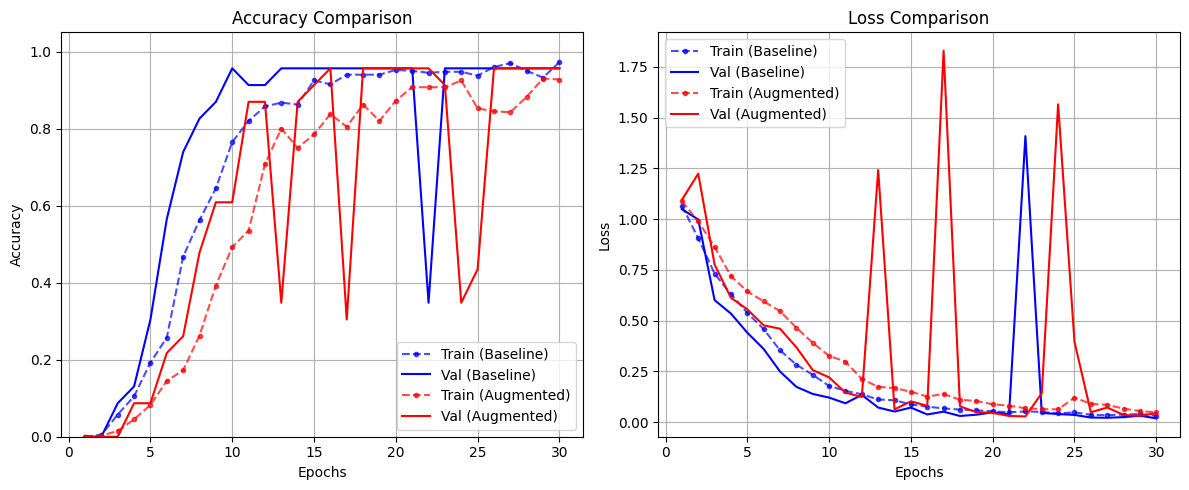


--- 최종 테스트 결과 비교 ---
Baseline 모델: 95.83% 정확도
Augmented 모델: 95.83% 정확도
성능 향상: 0.00%p


In [40]:
# --- 학습 결과 시각화 ---
import matplotlib.pyplot as plt

# 에폭 번호 리스트 생성 (1부터 시작)
epochs = range(1, num_epochs + 1)

# 그림 1: 정확도 비교
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)

# 실험 1 (Baseline) 결과 플롯
plt.plot(epochs, history_baseline['train_acc'], 'bo--', label='Train (Baseline)', alpha=0.7, markersize=3)
plt.plot(epochs, history_baseline['val_acc'], 'b-', label='Val (Baseline)', linewidth=1.5)

# 실험 2 (Augmented) 결과 플롯
plt.plot(epochs, history_augmented['train_acc'], 'ro--', label='Train (Augmented)', alpha=0.7, markersize=3)
plt.plot(epochs, history_augmented['val_acc'], 'r-', label='Val (Augmented)', linewidth=1.5)

# 그래프 설정
plt.title('Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.ylim(0, 1.05)

# 그림 2: 손실 비교
plt.subplot(1, 2, 2)

# 실험 1 (Baseline) 결과 플롯
plt.plot(epochs, history_baseline['train_loss'], 'bo--', label='Train (Baseline)', alpha=0.7, markersize=3)
plt.plot(epochs, history_baseline['val_loss'], 'b-', label='Val (Baseline)', linewidth=1.5)

# 실험 2 (Augmented) 결과 플롯
plt.plot(epochs, history_augmented['train_loss'], 'ro--', label='Train (Augmented)', alpha=0.7, markersize=3)
plt.plot(epochs, history_augmented['val_loss'], 'r-', label='Val (Augmented)', linewidth=1.5)

# 그래프 설정
plt.title('Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 테스트 결과 요약 출력
print("\n--- 최종 테스트 결과 비교 ---")
print(f"Baseline 모델: {test_acc_baseline:.2%} 정확도")
print(f"Augmented 모델: {test_acc_augmented:.2%} 정확도")
print(f"성능 향상: {(test_acc_augmented - test_acc_baseline) * 100:.2f}%p")